In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image
from scipy.special import expit

In [2]:
#INPUT PARAMETERS:
n_power = 2
dm_mass =  100 #GeV
step_size_cross_section =  6.4e-18
f_sky = 0.4
theta_fwhm = 1.5 * (np.pi/60./180.)
Tcmb = 2.7255 #2.726
l_min = 2
l_max = 2500
#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 
#6e-13 * pow(dm_mass,1.25) <- n=4 
#8e-7 * pow(dm_mass,1.3)   <- n=6 
list_param = ['omega_b','omega_dmb', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmb']
list_fiducial = [0.0224, 0.12, 0.6730804,  2.2e-9, 0.96, 0.07, 0.0]
list_step = [0.0001,     0.001,    0.004,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

import time
start_time = time.time()
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

Starting Time = 07:44:03


In [3]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl','lensing': 'yes','l_max_scalars': 2500,
    'omega_b': list_fiducial[0],'omega_dmb': list_fiducial[1],'h': list_fiducial[2],'A_s' : list_fiducial[3],'n_s' : list_fiducial[4], 'tau_reio' : list_fiducial[5],'sigma_dmb': list_fiducial[6],
    'm_dmb': dm_mass,
    'omega_cdm' : 1e-22,
    'n_dmb': n_power,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm':0.71611,
    'reionization_optical_depth_tol': 1e-07,
    'perturb_sampling_stepsize':0.01,
    'k_max_tau0_over_l_max' : 6,
    'gauge' : 'synchronous'
          }

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.lensed_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']
      
Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i])

<ipython-input-4-c504288a86de>:5: RuntimeWarning: invalid value encountered in true_divide
  frac_diff_tt = (aa_cl_tt - fiducial['tt'])/aa_cl_tt
<ipython-input-4-c504288a86de>:6: RuntimeWarning: invalid value encountered in true_divide
  frac_diff_ee = (aa_cl_ee - fiducial['ee'])/aa_cl_ee
<ipython-input-4-c504288a86de>:7: RuntimeWarning: invalid value encountered in true_divide
  frac_diff_pp = (aa_cl_pp - fiducial['pp'])/aa_cl_pp
<ipython-input-4-c504288a86de>:8: RuntimeWarning: invalid value encountered in true_divide
  frac_diff_kk = (aa_cl_kk - Cl_est_kk)/aa_cl_kk


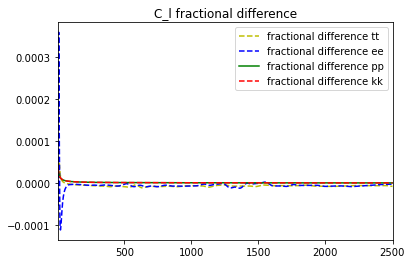

In [4]:
aa_cl_tt = np.load('MCMC_data/Cl_tt_n_0_1GeV.npy')/((1.0e6*Tcmb)**2)
aa_cl_pp = np.load('MCMC_data/Cl_pp_n_0_1GeV.npy')#/((1.0e6*Tcmb)**2)
aa_cl_ee = np.load('MCMC_data/Cl_ee_n_0_1GeV.npy')/((1.0e6*Tcmb)**2)
aa_cl_kk = np.load('MCMC_data/Cl_kk_n_0_1GeV.npy')#/((1.0e6*Tcmb)**2)
frac_diff_tt = (aa_cl_tt - fiducial['tt'])/aa_cl_tt
frac_diff_ee = (aa_cl_ee - fiducial['ee'])/aa_cl_ee
frac_diff_pp = (aa_cl_pp - fiducial['pp'])/aa_cl_pp
frac_diff_kk = (aa_cl_kk - Cl_est_kk)/aa_cl_kk
plt.plot(frac_diff_tt, 'y--',label="fractional difference tt")
plt.plot(frac_diff_ee, 'b--',label="fractional difference ee")
plt.plot(frac_diff_pp, 'g-',label="fractional difference pp")
plt.plot(frac_diff_kk, 'r--',label="fractional difference kk")
#plt.yscale('log')
#plt.ylim(5e-22,1e-6)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('C_l fractional difference')
plt.savefig("C_l_fraction_compare.png")
plt.show()

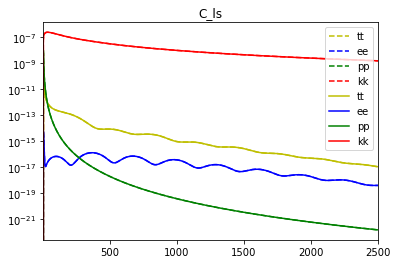

In [5]:
plt.plot(fiducial['tt'], 'y--',label="tt")
plt.plot(fiducial['ee'], 'b--',label="ee")
plt.plot(fiducial['pp'], 'g--',label="pp")
plt.plot(Cl_est_kk, 'r--',label="kk")

plt.plot(aa_cl_tt, 'y-',label="tt")
plt.plot(aa_cl_ee, 'b-',label="ee")
plt.plot(aa_cl_pp, 'g-',label="pp")
plt.plot(aa_cl_kk, 'r-',label="kk")

plt.yscale('log')
#plt.ylim(5e-22,1e-6)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('C_ls')
plt.savefig("C_l_compare.png")
plt.show()

In [6]:
a = np.load('noise/CMB_S4_noise.npy')
nl_tt = a[0] /((1.0e6*Tcmb)**2)
nl_ee = a[1] /((1.0e6*Tcmb)**2)
nl_kk = a[2] /((1.0e6*Tcmb)**2)

In [7]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.lensed_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [8]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmb':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

In [ ]:
#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(10,4))
axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')
axs[0, 1].plot(dict_norm_der['omega_dmb'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmb}$')
axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')
axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')
axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')
axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')
axs[1, 2].plot(dict_norm_der['sigma_dmb'], 'tab:red')
axs[1, 2].set_title('sigma_dmb')
for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.savefig("fisher_plots/derivative_C_l_TT_{}GeV_n={}_S4.png".format(str(dm_mass),str(n_power)))

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
plt.plot(nl_tt, '-',label="N_TT")
plt.plot(nl_ee  , '-',label="N_EE")
plt.plot(nl_kk , '-',label="N_kk")
#plt.plot(N_EE*((1.0e6*Tcmb)**2) , '-',label="Polarization Noise")
#plt.plot(N_KK*((1.0e6*Tcmb)**2) , '--',label="Lensing Noise")
plt.yscale('log')
plt.ylim(5e-23,1e-19)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Noise (normalized)')
plt.show()

We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)


Computing $C_l$ only using temperature power spectrum for planck baseline. 

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)
 $$

Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
    C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } & 0 \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } & 0 \\
    0 & 0 & \frac{\partial C_{\ell}^{\kappa\kappa}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [ ]:
dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

In [ ]:
dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append((1.0/4) * (math.factorial(l+2)/math.factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)
#print(dC_lkk)

In [ ]:
MAT_d_cl = [ 
            [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial), 0],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial), 0],
            [0, 0, dC_lkk]
           ]

MAT_cl = [ [fiducial['tt'] + nl_tt, fiducial['te'], 0], 
           [fiducial['te'], fiducial['ee'] + nl_ee, 0],
           [0, 0,  Cl_est_kk + nl_kk] ]

In [ ]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l], 0], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l], 0],
              [0, 0, MAT_d_cl[2][2][i][l]]]
    
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l], 0],
          [MAT_cl[1][0][l], MAT_cl[1][1][l], 0],
          [0, 0, MAT_cl[2][2][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [ ]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)
    
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

In [ ]:
print(F)

In [ ]:
import fishchips.util
cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);
fig.savefig("fisher_plots/triagular_ellipses_{}GeV_n={}_S4.png".format(str(dm_mass),str(n_power)))

In [ ]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48,"2-sigma zack's method =")

In [ ]:
print(dat)

In [ ]:
outF = open("fisher_data/S4_n={}/{}GeV.txt".format(str(n_power),str(dm_mass)), "w")

for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))